# 5章 拡散モデル

## 事前準備

In [1]:
!curl -L -o genaibook.zip https://github.com/oreilly-japan/hands-on-generative-ai-ja/releases/download/genaibook/genaibook.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4678  100  4678    0     0  13814      0 --:--:-- --:--:-- --:--:-- 13814


In [2]:
!unzip genaibook.zip

Archive:  genaibook.zip
Made with MacWinZipper (http://tidajapan.com/macwinzipper)
  inflating: genaibook/__init__.py   
  inflating: genaibook/core.py       


In [3]:
!pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 90.9 MB/s eta 0:00:00


In [4]:
!pip install datasets==4.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


## 制御の追加：条件付き拡散モデル


In [ ]:
import diffusers
import transformers

transformers.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()

### データの準備


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

fashion_mnist/train-00000-of-00001.parqu(…):   0%|          | 0.00/30.9M [00:00<?, ?B/s]

fashion_mnist/test-00000-of-00001.parque(…):   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

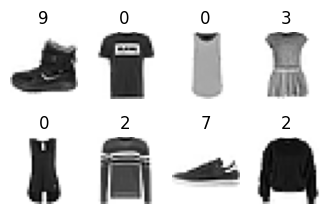

In [ ]:
from datasets import load_dataset
from genaibook.core import show_images

import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray_r"

fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]["image"][:8]
classes = fashion_mnist["train"]["label"][:8]
show_images(clothes, titles=classes, figsize=(4, 2.5))

In [ ]:
import torch
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # ランダムに反転させる（データオーグメンテーション）
        transforms.ToTensor(),  # テンソル形式 (0, 1) に変換する
        transforms.Pad(2),  # 周囲に2ピクセルの枠を設定する
        transforms.Normalize([0.5], [0.5]),  # (-1, 1)の範囲になるように正規化する
    ]
)


def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images, "labels": examples["label"]}


train_dataset = fashion_mnist["train"].with_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True
)

### クラス条件付きモデルの作成


In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # グレースケール画像なのでチャンネル数は1
    out_channels=1,
    sample_size=32,
    block_out_channels=(32, 64, 128, 256),
    num_class_embeds=10,  # クラスの条件付けを有効化する
)

In [ ]:
x = torch.randn((1, 1, 32, 32))
with torch.inference_mode():
    out = model(x, timestep=7, class_labels=torch.tensor([2])).sample
out.shape

torch.Size([1, 1, 32, 32])

### モデルの訓練


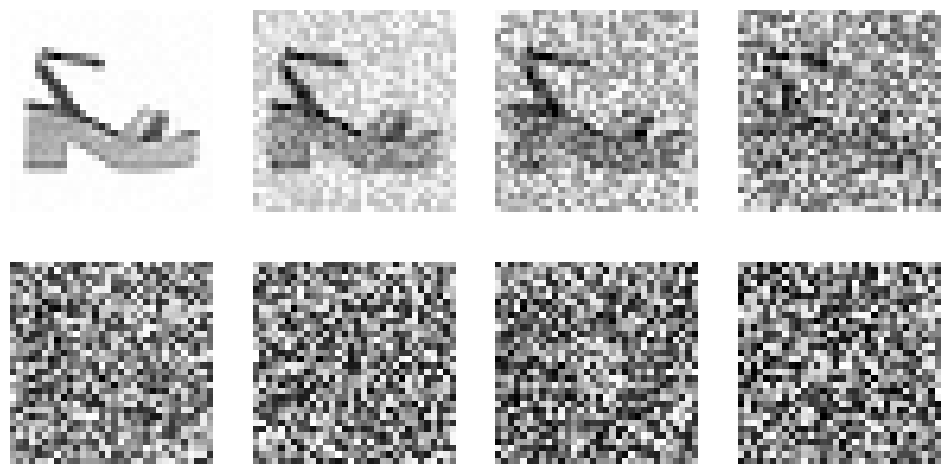

In [ ]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

# データセットから8枚の画像を読み込み
# ノイズの量を徐々に増やしていく
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [ ]:
from torch.nn import functional as F
from tqdm import tqdm

from genaibook.core import get_device

# スケジューラーを初期化する
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
)

num_epochs = 25
lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []  # 後で表示するために損失を保存しておくリスト

device = get_device()
model = model.to(device)

# モデルを訓練する（しばらく時間がかかる）
for epoch in (progress := tqdm(range(num_epochs))):
    for step, batch in (
        inner := tqdm(
            enumerate(train_dataloader),
            position=0,
            leave=True,
            total=len(train_dataloader),
        )
    ):
        # 入力画像とクラスを読み込む
        clean_images = batch["images"].to(device)
        class_labels = batch["labels"].to(device)

        # 画像に加えるノイズをサンプリングする
        noise = torch.randn(clean_images.shape).to(device)

        # 各画像ごとにランダムなタイムステップをサンプリングする
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # タイムステップごとのノイズ量に従って
        # 画像にノイズを加える
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # ノイズに対するモデルの予測値を得る
        # モデルにクラスラベルを渡している点に注目
        noise_pred = model(
            noisy_images,
            timesteps,
            class_labels=class_labels,
            return_dict=False,
        )[0]

        # 予測値と実際のノイズを比較する
        loss = F.mse_loss(noise_pred, noise)

        # 損失を更新し、表示する
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")

        # 後で表示できるように損失を保存する
        losses.append(loss.item())

        # この損失に基づきモデルのパラメーターを更新する
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 25/25 [17:33<00:00, 42.14s/it]


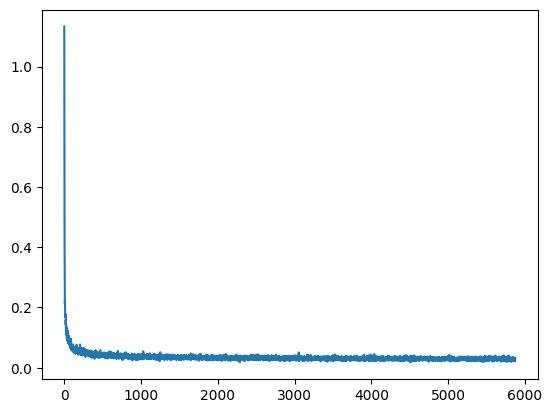

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses);

In [ ]:
torch.save(model, "mnist_classcond.pth")

### サンプリング

In [ ]:
def generate_from_class(class_to_generate, n_samples=8):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        # モデルによる予測値を得る
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        # ステップごとにサンプルを更新する
        sample = scheduler.step(noise_pred, t, sample).prev_sample

    return sample.clip(-1, 1) * 0.5 + 0.5

1000it [00:28, 34.97it/s]


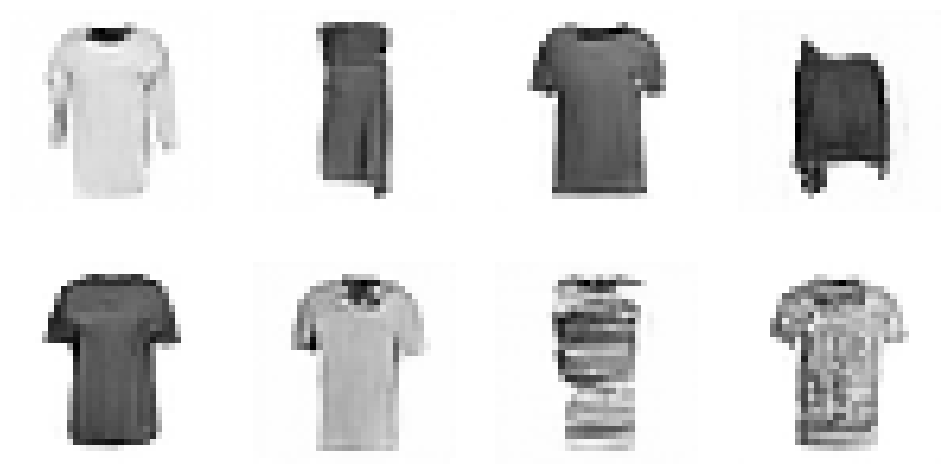

In [ ]:
# Tシャツ（クラス0）の画像を生成する
images = generate_from_class(0)
show_images(images, nrows=2)

1000it [00:27, 36.37it/s]


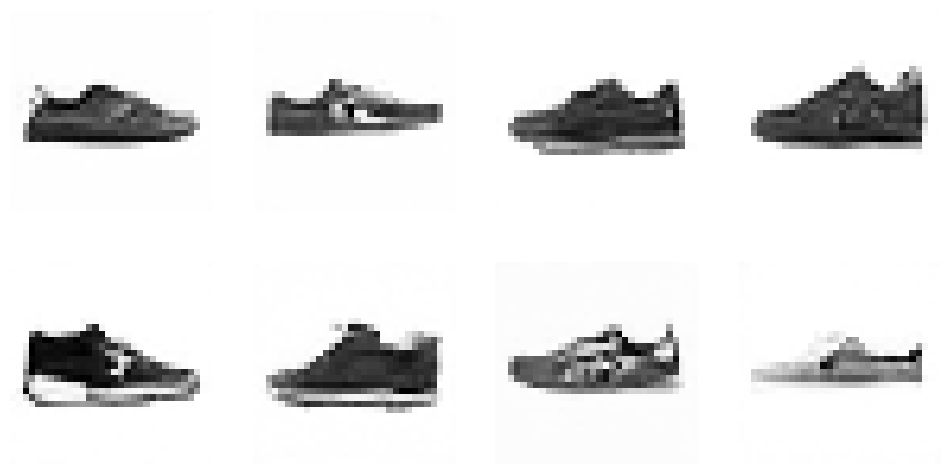

In [ ]:
# スニーカー（クラス7）の画像を生成する
images = generate_from_class(7)
show_images(images, nrows=2)

1000it [00:27, 36.44it/s]


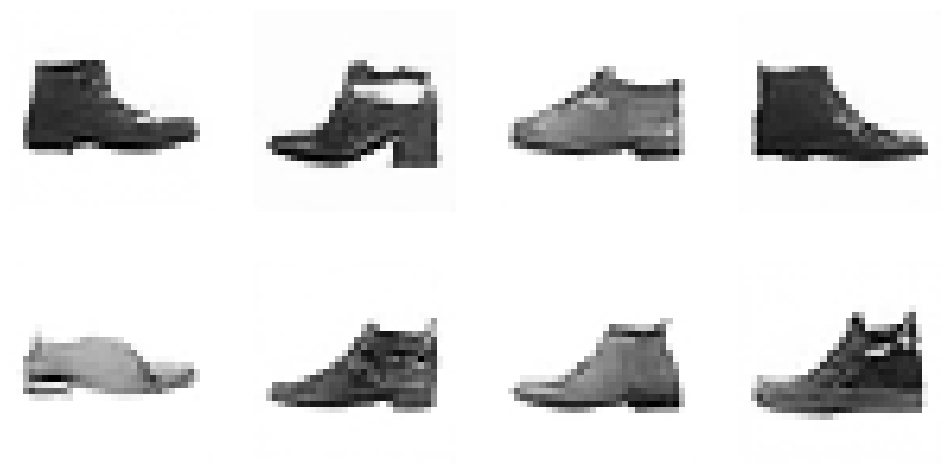

In [ ]:
# ブーツ（クラス9）の画像を生成する
images = generate_from_class(9)
show_images(images, nrows=2)

## Stable Diffusionの構成要素の詳解

In [10]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

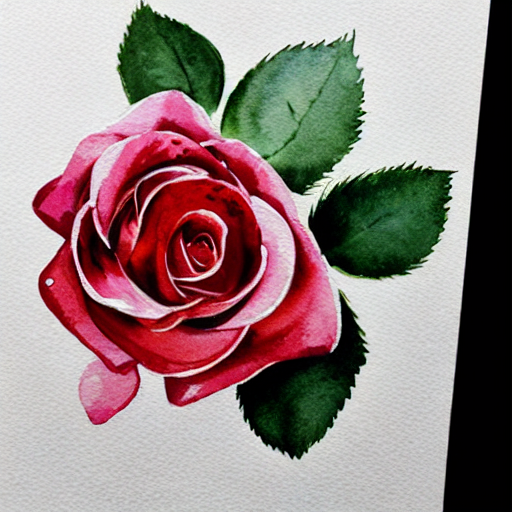

In [28]:
pipe("Watercolor illustration of a rose").images[0]

### テキストエンコーダー

In [12]:
prompt = "A photograph of a puppy"

# テキストをトークンの列に変換する
text_input = pipe.tokenizer(
    prompt,
    return_tensors="pt",
)

# トークンと対応するIDを出力する
for t in text_input["input_ids"][0]:
    print(t, pipe.tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(8853) photograph</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>


In [13]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
print("Text embeddings shape:", text_embeddings.shape)

Text embeddings shape: torch.Size([1, 7, 768])


### 変分オートエンコーダー（VAE）


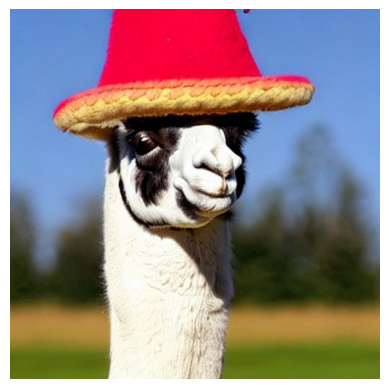

In [14]:
from genaibook.core import load_image, show_image, SampleURL

im = load_image(
    SampleURL.LlamaExample,
    size=(512, 512),
)
show_image(im);

In [15]:
from torchvision import transforms

with torch.inference_mode():
    # 画像を処理する
    tensor_im = transforms.ToTensor()(im).unsqueeze(0).to(device) * 2 - 1
    tensor_im = tensor_im.half()

    # 画像をエンコードする
    latent = pipe.vae.encode(tensor_im)

    # 潜在分布からサンプリングする
    latents = latent.latent_dist.sample()
    latents = latents * 0.18215

latents.shape

torch.Size([1, 4, 64, 64])

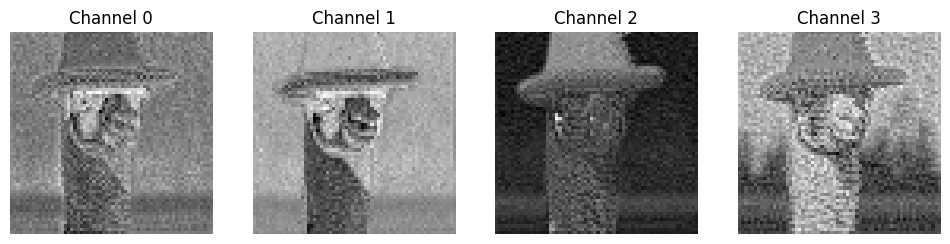

In [ ]:
# 潜像表現の各チャンネルを可視化する
show_images(
    [l for l in latents[0]],
    titles=[f"Channel {i}" for i in range(latents.shape[1])],
    ncols=4,
)

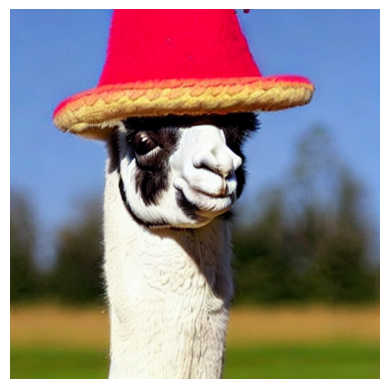

In [20]:
with torch.inference_mode():
    image = pipe.vae.decode(latents / 0.18215).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float());

### 分類フリーガイダンス（CFG）


In [21]:
images = []
prompt = "An oil painting of a collie in a top hat"
for guidance_scale in [1, 2, 4, 12]:
    torch.manual_seed(0)
    image = pipe(prompt, guidance_scale=guidance_scale).images[0]
    images.append(image)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

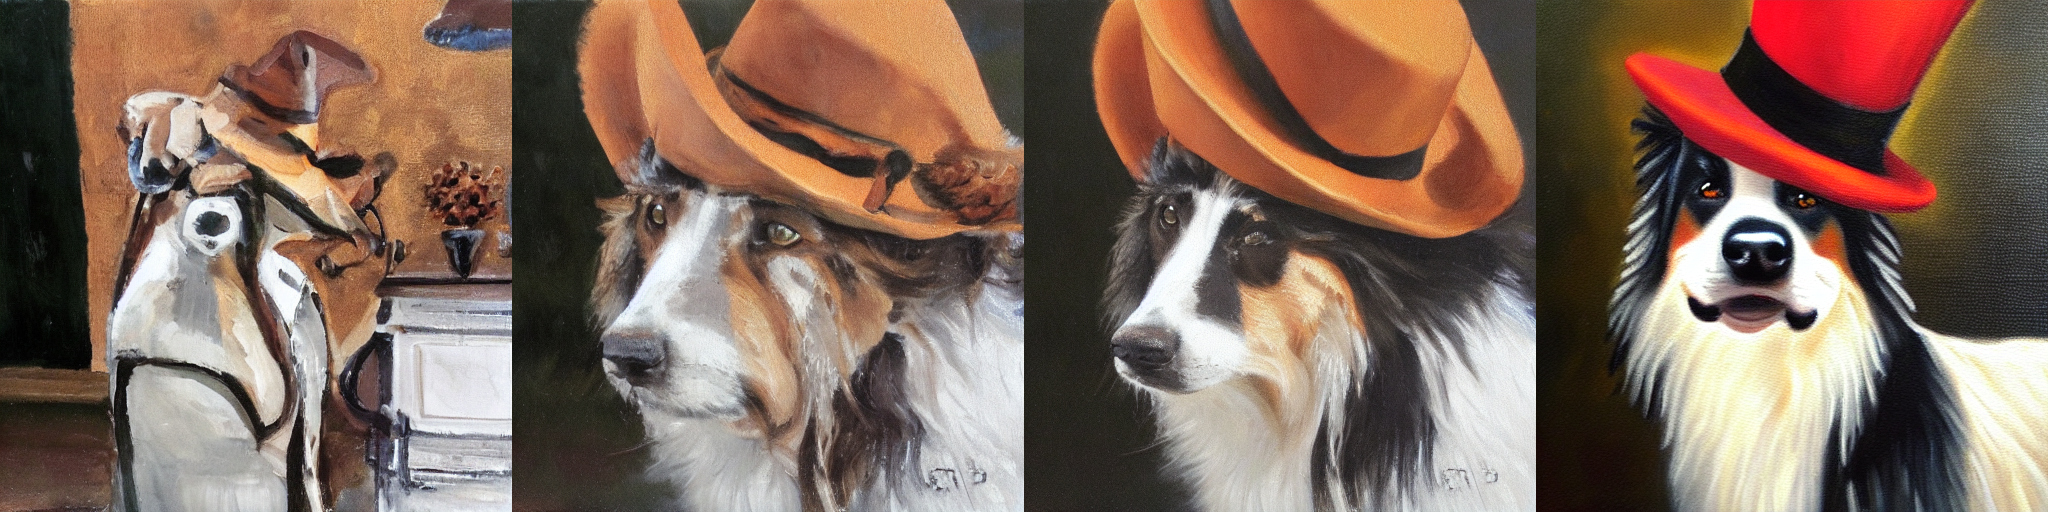

In [22]:
from genaibook.core import image_grid

image_grid(images, 1, 4)

## すべてをまとめる：コメント付きサンプリングループ


In [23]:
# 設定情報
prompt = [
    "Acrylic palette knife painting of a flower"
]  # 何を生成したいのか
height = 512  # Stable Diffusionの画像の高さ
width = 512  # Stable Diffusionの画像の幅
num_inference_steps = 30  # ノイズ除去のステップ数
guidance_scale = 7.5  # CFGのガイダンススケール
seed = 42  # 生成のシード値

In [24]:
# 入力をトークン化する
text_input = pipe.tokenizer(
    prompt,
    padding="max_length",  # 最大長までパディングし、入力の形状を揃える
    return_tensors="pt",
)

# 非条件付き入力（空文字列）についても同様に処理する
uncond_input = pipe.tokenizer(
    "",
    padding="max_length",
    return_tensors="pt",
)

# 両方の埋め込みをテキストエンコーダーに通す
with torch.inference_mode():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# 2つのテキスト埋め込みを結合する
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [25]:
# スケジューラーを準備する
pipe.scheduler.set_timesteps(num_inference_steps)

# ランダムに初期化した潜在表現を準備する
latents = (
    torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
    )
    .to(device)
    .half()
)
latents = latents * pipe.scheduler.init_noise_sigma

In [26]:
for t in pipe.scheduler.timesteps:
    # 2つのテキスト埋め込み（非条件付きと条件付き）に対応するよう、
    # 潜在表現を2つ複製する
    latent_input = torch.cat([latents] * 2)
    latent_input = pipe.scheduler.scale_model_input(latent_input, t)

    # 潜在表現それぞれについてノイズ残差を予測する
    with torch.inference_mode():
        noise_pred = pipe.unet(
            latent_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # 非条件付きと条件付きの予測結果を分ける
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # CFGを実行する
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )

    # 次のタイムステップ用に潜在表現を更新する
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

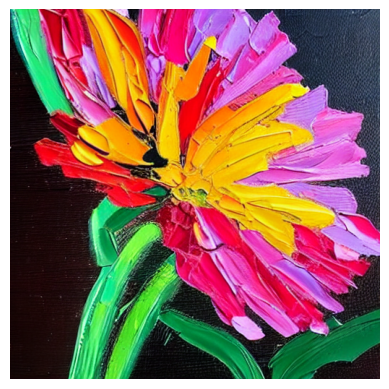

In [27]:
# 画像の潜在表現をスケーリングし、VAEでデコードする
latents = 1 / pipe.vae.config.scaling_factor * latents
with torch.inference_mode():
    image = pipe.vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)

show_image(image[0].float());

## 解答


### プロジェクト課題：GradioでインタラクティブなMLデモを構築する

もっとも基本的なコードを見てどのように動作するかを理解しよう

In [ ]:
import gradio as gr


def greet(name):
    return "Hello " + name


demo = gr.Interface(fn=greet, inputs="text", outputs="text")
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://130c869e4e4eb2fd3b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Stable Diffusionをデモしてみよう。まずはパイプラインを読み込み、入力を受け取って出力を返す関数を作成する。

In [ ]:
import torch
from diffusers import AutoencoderKL, StableDiffusionPipeline

device = get_device()

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16
).to(device)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def generate(prompt):
    return pipe(prompt, num_samples=1).images[0]


demo = gr.Interface(generate, inputs="text", outputs="image")
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c1126d0b6e30e4ca0d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


さらに新しい機能を追加してみよう。

In [ ]:
def generate(prompt, negative_prompt, num_steps):
    return pipe(
        prompt,
        num_samples=1,
        negative_prompt=negative_prompt,
        num_inference_steps=num_steps,
    ).images[0]


demo = gr.Interface(
    generate,
    inputs=[
        gr.Textbox(
            label="Prompt",
            lines=2,
        ),
        gr.Textbox(
            label="Negative prompt",
            lines=2,
        ),
        gr.Slider(
            minimum=30, maximum=100, step=5, value=50, label="Number of steps"
        ),
    ],
    outputs="image",
    title="Stable Diffusion demo",
)
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://973f101401777d88ca.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### 演習

**1. クラス条件付き拡散モデルの訓練のプロセスは、非条件付きモデルとどのように異なるか。特に、入力データと使用される損失関数の観点から説明せよ。**

プロセス自体はほぼ同じである。ただし、モデルには条件付けとしてラベルも入力される。このことによって損失関数が影響を受けるわけではない。損失関数は生成されたデータを元のノイズと比較することが主な目的であり、条件付けのラベルの有無とは関係がない。

**2. タイムステップ埋め込みは、拡散プロセス中の画像の品質や変化にどのような影響を及ぼすか。**

前章で扱ったモデルは、タイムステップで条件付けされる拡散モデルの特殊なケースとみなすことができる。タイムステップ埋め込みは、現在の拡散プロセスにおけるステップの情報をモデルに提供する。これにより、プロセスが進むにつれて、より一貫性がありリアリティのある画像を生成できるようになる。タイムステップはこれまでにどの程度拡散が進んだかを示すため、モデルはその情報を活用して洗練された画像を生成できる。

**3. 潜在拡散（Latent Diffusion）と通常の拡散との違いを説明せよ。潜在拡散を使用する場合のトレードオフは何か。**

潜在拡散と通常の拡散は、処理を行う空間が異なる。通常の拡散モデルは画像のピクセルの値を直接操作するため、特に大きな画像の場合、計算コストが高くなりスケーラビリティに欠ける。これに対し、潜在拡散はVAEなどによって構成される低次元の潜在空間で処理を行うため、よりスケーラブルかつメモリ効率に優れる。

潜在拡散の利点は、メモリ使用量の削減と高速な生成が可能である点だ。一方で、トレードオフとして、潜在空間で処理が行われるため解釈性がやや損なわれることがある。また、VAEコンポーネントを導入することで、モデルの構成が複雑化し、訓練の難易度が増す可能性もある。

**4. テキストプロンプトは、どのようにモデルに組み込まれるか。**

本書の3章で述べた通り、CLIPは画像とテキストの両方を扱うことができる。テキストの処理には、デコーダー専用のTransformer（2章で紹介）をテキストエンコーダーとして用いる。このテキストエンコーダーによってテキストプロンプトの埋め込みが生成され、それが追加の入力として拡散モデルに与えられることで、テキストプロンプトに沿った画像をモデルが生成できるようになる。

**5. モデルベースのガイダンスとCFGの違いは何か。CFGの利点は何か。**

* **モデルベースのガイダンス:** 別の分類モデルなどを用意して生成プロセスを誘導するアプローチである。分類モデルによって計算した損失を推論プロセスに組み込む。
* **CFG（分類フリーガイダンス）:** 別の分類モデルに依存せず、拡散モデルの条件付け入力を直接利用してガイダンスを行うアプローチである。具体的には、条件付きおよび非条件付きの拡散モデルの生成結果を組み合わせる。これにより、テキストプロンプトを強く生成プロセスに反映でき、かつ追加のモデルが不要となる。


**6. ネガティブプロンプトを使用するとどのような効果があるか `pipe(…, negative_prompt="")` を使って実験してみよう。Stable Diffusionを使い、どのように画像生成を誘導できるだろうか。**

ネガティブプロンプトを使用することで、特定の属性やスタイルを画像生成から排除するよう誘導できる。たとえば、猫の画像を生成したいが黒猫は生成させたくない場合、ネガティブプロンプトに「黒猫」と設定すれば、モデルが黒猫を生成しにくくなるように制御できる。

**7. 生成される画像から白い帽子を取り除きたいとしよう。ネガティブプロンプトをどのように設定すればよいだろうか。まずはハイレベルのパイプラインで実装し、その後エンドツーエンドの推論の例を適用しよう。（ヒント：分類器フリーの条件付けのランダムな部分のみを修正すればよい。）.**

まず、モデルを読み込む

In [ ]:
import torch
from diffusers import AutoencoderKL, StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16
).to(device)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

最初の画像を見てみよう

  0%|          | 0/50 [00:00<?, ?it/s]

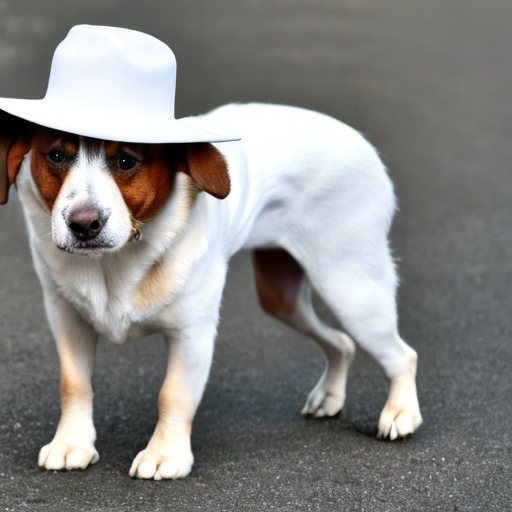

In [ ]:
pipe("A dog wearing a white hat").images[0]

ネガティブプロンプトを使って白い帽子を取り除く

  0%|          | 0/50 [00:00<?, ?it/s]

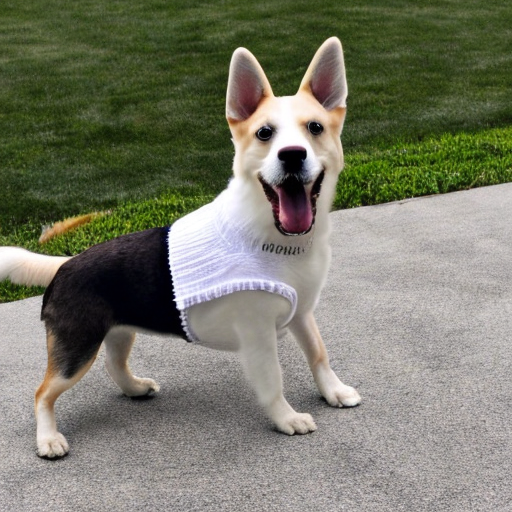

In [ ]:
pipe("A dog wearing a white hat", negative_prompt="a white hat").images[0]

推論を行うコード全体を示す

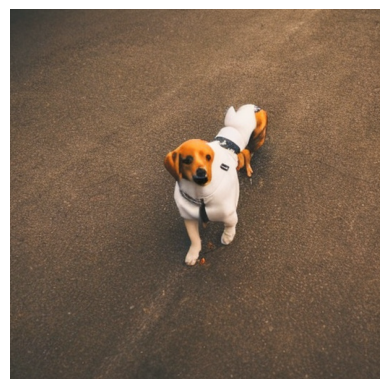

In [ ]:
from genaibook.core import show_image

# 今までと同様
guidance_scale = 7.5
text_input = pipe.tokenizer(
    "A dog with a white hat",
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

# 変更点はこれだけである。非条件付き入力ではなく、ネガティブプロンプトを使っている
neg_input = pipe.tokenizer(
    "White hat",
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    return_tensors="pt",
)

with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    neg_prompt_embeddings = pipe.text_encoder(neg_input.input_ids.to(device))[0]

# 2種類のテキスト埋め込みを結合する
text_embeddings = torch.cat([neg_prompt_embeddings, text_embeddings])

pipe.scheduler.set_timesteps(30)
latents = (
    torch.randn(
        (1, pipe.unet.config.in_channels, 64, 64),
    )
    .to(device)
    .half()
)
latents = latents * pipe.scheduler.init_noise_sigma

for i, t in enumerate(pipe.scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

latents = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float());

**8. SDXLにおいて、「original size（元のサイズ）」の条件付け信号として`(1024, 1024)`の代わりに`(256, 256)`を使用すると何が起こるか。さらに、クロップ座標として`(0, 0)`以外を指定した場合はどうなるか。その理由も説明せよ。**

* 「original size」の条件付け信号として(1024, 1024)ではなく(256, 256)を指定した場合も、モデルは出力画像をデフォルトの解像度(1024, 1024)で生成する。ただし、この場合、画像の細部が荒くなったり、ぼやけたり拡大されたような見た目になることが多い。これは、訓練時に小さな画像が拡大され、その元のサイズを条件付け信号として利用するためである。したがって、モデルは、小さい画像を大きく拡大したときの特徴的な見た目を学習していることになる。そのため、推論時に同じ信号を与えると、モデルは小さな画像を拡大したかのような見た目の出力を生成しやすくなる。
* クロップ座標として(0, 0)を指定すると、被写体が画像の中央に配置されやすくなる。別のクロップ座標を指定すると、被写体は画像内のさまざまな位置に配置される。

### 課題

**9. _青色のガイダンス_   生成画像を特定の色、たとえば青に偏らせたいとしよう。どうすればよいだろうか。最初のステップは、最小化したい条件付け関数、つまりこの場合は色の損失を定義することだ。**

In [ ]:
def color_loss(images, target_color=(0.1, 0.5, 0.9)):
    """対象の色（R, G, B）を指定し、画像の各ピクセルがその色から平均してどれだけ離れているかを
        損失として返す。"""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # 対象の色を (-1, 1) の範囲で正規化する
    target = target[
        None, :, None, None
    ]  #  画像を（b, c, h, w）の形で扱えるように形状を整える
    error = torch.abs(
        images - target
    ).mean()  # 画像の各ピクセルと対象の色の平均絶対誤差を求める
    return error

この損失関数をもとに、_x_を損失関数の方向に修正するサンプリングループを書こう。訓練の必要はない

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.


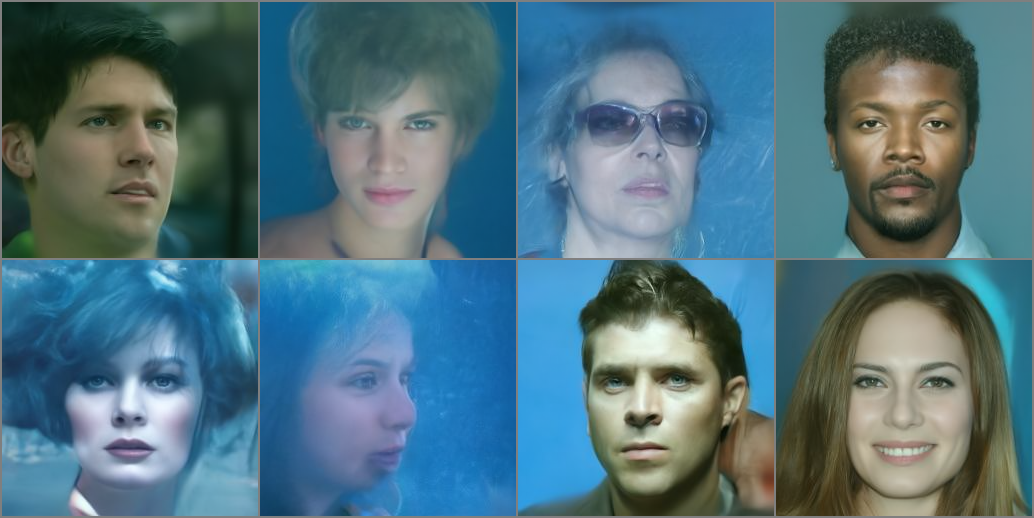

In [ ]:
import numpy as np
import torch
import torchvision
from diffusers import DDPMPipeline
from PIL import Image

# モデルをセットアップする
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device)
pipe.scheduler.set_timesteps(num_inference_steps=30)
guidance_loss_scale = 60  # この値を5や100に変更して試すのもよい

# 入力をセットアップする
x = torch.randn(8, 3, 256, 256).to(device)

# メインループ
for i, t in enumerate(pipe.scheduler.timesteps):
    with torch.no_grad():
        noise_pred = pipe.unet(x, t)["sample"]

    # x.requires_grad を Trueに設定する
    x = x.requires_grad_()

    # 予測値のx0を得る
    scheduler_output = pipe.scheduler.step(
        noise_pred, t, x
    ).pred_original_sample

    # 損失を計算して勾配を得る
    loss = color_loss(scheduler_output) * guidance_loss_scale
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # この勾配に基づいてxを修正する
    x = x.detach() + cond_grad

    # スケジューラーのstepを実行する
    x = pipe.scheduler.step(noise_pred, t, x).prev_sample

# 出力結果を表示する
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))